# Gravity assist model 

In [2]:
import numpy as np

# parameters
dt = 0.1 #[h]
N = 3000; #number of samples
T = N * dt #whole time of simulation [h]
G = 6.67430 * (10**(-11-3-3-3)) * 3600**2  #[km^3 / kg*h^2]
M = 189.819 * 10**23 / 36 # Mass of the planet (Jupiter) [kg]
x0p = 0 #start location of the planet
y0p = 0
x0s = 70000 #start location of the spacecraft [km]
y0s = -80000
Vxp = 2000 #velocity of the planet [km/h]
Vyp = 0
vx0s = -1000 #initial velocity of the spacecraft [km/h]
vy0s = 700
m = 1136 # Mass of the spacecraft [kg] 


#calculation variables
Xs = np.zeros(N) #x axis location of a spacecraft
Ys = np.zeros(N) #y axis location of a spacecraft

Xp = np.zeros(N) #x axis location of a planet
Yp = np.zeros(N) #y axis location of a planet

Vxs = np.zeros(N) #x axis velocity of a spacecraft
Vys = np.zeros(N) #y axis vleocity of a spacecraft


#intial state
Xs[0] = x0s
Ys[0] = y0s

Xp[0] = x0p
Yp[0] = y0p

Vxs[0] = vx0s
Vys[0] = vy0s

## Euler–Cromer method

In [3]:
def calculateRange(xp,yp,xs,ys):
    return np.sqrt((xp-xs)**2+(yp-ys)**2)

def calculateVelocity(Vi,loci,r):
    return Vi - (G*M*loci)/(r**3) * dt

def calculatePosition(loci, Vi_):
    return loci + Vi_*dt

In [4]:
#Simple iterative approach

for i in range(1,N):
    # range between planet and spacecraft
    r = calculateRange(Xp[i-1],Yp[i-1],Xs[i-1],Ys[i-1])
    
    # velocity of the spacecraft
    Vxs[i] = calculateVelocity(Vxs[i-1],Xs[i-1],r)
    Vys[i] = calculateVelocity(Vys[i-1],Ys[i-1],r)
    
    # location of a spacecraft
    Xs[i] = calculatePosition(Xs[i-1],Vxs[i])
    Ys[i] = calculatePosition(Ys[i-1],Vys[i])
    
    # location of a planet
    Xp[i] = calculatePosition(Xp[i-1],Vxp)
    Yp[i] = calculatePosition(Yp[i-1],Vyp)

## 4th order Runge-Kutta method

In [5]:
import math

class State:
    def __init__(self, x, y, vx, vy, m):
        self._x, self._y, self._vx, self._vy, self._m = x, y, vx, vy, m

    def __repr__(self):
        return 'x:{x} y:{y} vx:{vx} vy:{vy} m:{m}'.format(
            x=self._x, y=self._y, vx=self._vx, vy=self._vy, m=self._m)


class Derivative:
    def __init__(self, dx, dy, dvx, dvy):
        self._dx, self._dy, self._dvx, self._dvy = dx, dy, dvx, dvy

    def __repr__(self):
        return 'dx:{dx} dy:{dy} dvx:{dvx} dvy:{dvy}'.format(
            dx=self._dx, dy=self._dy, dvx=self._dvx, dvy=self._dvy)



def acceleration(obj_a, obj_b, unused_t):
        dx = obj_b._x - obj_a._x
        dy = obj_b._y - obj_a._y
        dr = math.sqrt(dx*dx + dy*dy)  # distance
        force = G*obj_b._m/(dr**3) if dr>1e-10 else 0.
        ax = force*dx
        ay = force*dy
        return (ax, ay)

#calculate obj_a according to obj_b
def initialDerivative(obj_a,obj_b, t):
        ax, ay = acceleration(obj_a, obj_b, t)
        return Derivative(obj_a._vx, obj_a._vy, ax, ay)

    #calculate obj_a according to obj_b
def nextDerivative(initialState, obj_b, derivative, t, dt):
        state = State(0., 0., 0., 0., 0.)
        state._x = initialState._x + derivative._dx*dt
        state._y = initialState._y + derivative._dy*dt
        state._vx = initialState._vx + derivative._dvx*dt
        state._vy = initialState._vy + derivative._dvy*dt
        ax, ay = acceleration(state, obj_b, t+dt)
        return Derivative(state._vx, state._vy, ax, ay)

    #calculate obj_a according to obj_b
def update_obj(obj_a, obj_b, t, dt):
        a = initialDerivative(obj_a,obj_b, t)
        b = nextDerivative(obj_a,obj_b, a, t, dt*0.5)
        c = nextDerivative(obj_a,obj_b, b, t, dt*0.5)
        d = nextDerivative(obj_a,obj_b, c, t, dt)
        dxdt = 1.0/6.0 * (a._dx + 2.0*(b._dx + c._dx) + d._dx)
        dydt = 1.0/6.0 * (a._dy + 2.0*(b._dy + c._dy) + d._dy)
        dvxdt = 1.0/6.0 * (a._dvx + 2.0*(b._dvx + c._dvx) + d._dvx)
        dvydt = 1.0/6.0 * (a._dvy + 2.0*(b._dvy + c._dvy) + d._dvy)
        
        return State(obj_a._x + dxdt*dt,obj_a._y + dydt*dt,obj_a._vx + dvxdt*dt, obj_a._vy + dvydt*dt, obj_a._m)

In [6]:
planet = State(x0p, y0p, Vxp, Vyp,M)
starcraft = State(x0s, y0s, vx0s, vy0s,m)
starcraft_states=[starcraft]
planet_states=[planet]
t=0.
for i in range(1,N):
        t += dt
        starcraft_states.append(update_obj(starcraft_states[i-1],planet_states[i-1],t,dt))
        planet_states.append(update_obj(planet_states[i-1],starcraft_states[i-1],t,dt))


In [7]:
xs = [i._x for i in starcraft_states]
ys = [i._y for i in starcraft_states]
xp = [i._x for i in planet_states]
yp = [i._y for i in planet_states]
vxs = [i._vx for i in starcraft_states]
v_value = [math.sqrt(i._vx**2+i._vy**2) for i in starcraft_states]



## Comparison of Euler–Cromer method and 4th order Runge-Kutta method 

In [8]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 

plt.style.use('seaborn-white')

fig, ax = plt.subplots()
plt.title("Spacecraft and planet trajectory Euler–Cromer method") 
fig.set_size_inches(7, 5)
line, = ax.plot(Xs,Ys, label="spacecraft") 
line2, = ax.plot(Xp,Yp, label="planet") 
ax.legend()
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
plt.show()

fig, ax = plt.subplots()
plt.title("Spacecraft and planet trajectory 4th order Runge-Kutta method") 
fig.set_size_inches(7, 5)
line, = ax.plot(xs,ys, label="spacecraft") 
line2, = ax.plot(xp,yp, label="planet") 
ax.legend()
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
plt.show()




<Figure size 700x500 with 1 Axes>

<Figure size 700x500 with 1 Axes>

## Euler–Cromer method results

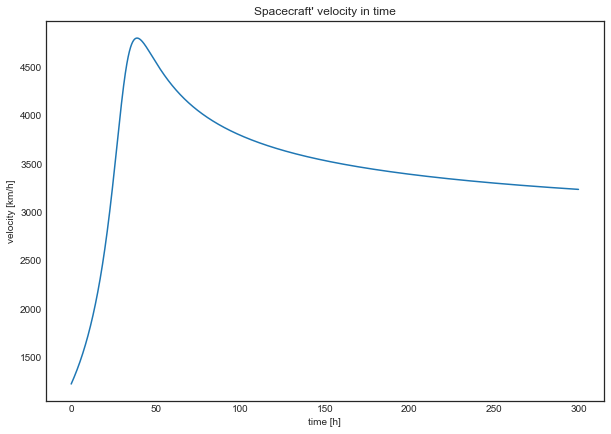

In [9]:
fig, ax = plt.subplots()
plt.title("Spacecraft' velocity in time") 
fig.set_size_inches(10, 7)
line, = ax.plot([i*dt for i in range(N)],v_value) 
ax.set_xlabel('time [h]')
ax.set_ylabel('velocity [km/h]')
plt.show()

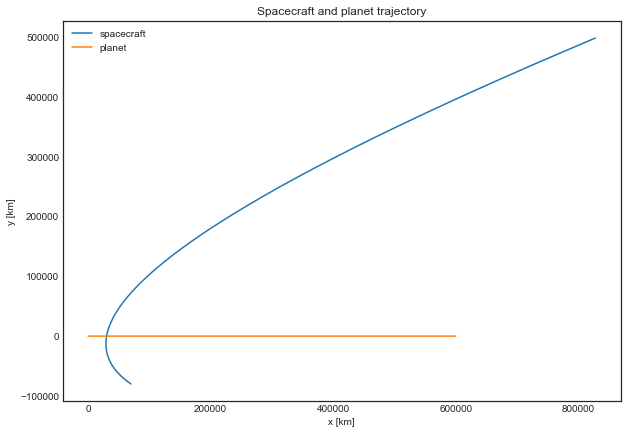

In [10]:
fig, ax = plt.subplots()
plt.title("Spacecraft and planet trajectory") 
fig.set_size_inches(10, 7)
line, = ax.plot(xs,ys, label="spacecraft") 
line2, = ax.plot(xp,yp, label="planet") 
ax.legend()
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
plt.show()

### Value of velocity increase

In [11]:
v_value[-1]-v_value[1]

2008.986424400737

### Animated plots

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.set_xlim(-10000,150000)
ax.set_ylim(-100000,150000)
line, = ax.plot([], [],label="spacecraft") 
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')

ax2 = ax.twinx()
ax2.set_ylim(-100000,150000)

line2, = ax.plot([], [], 'ro',label="planet") 

ax3 = ax.twinx()
line3, = ax.plot([], [], 'bo') 
ax.legend(loc='upper left')


# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    line2.set_data([], []) 
    line3.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], []

# animation function 
def animate(i): 
    # x, y values to be plotted 
    x = xs[8*i]
    y = ys[8*i]
    x2 = xp[8*i]
    y2 = yp[8*i] if yp[i]>0.001 else 0
    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    line.set_data(xdata,ydata) 
    line2.set_data(x2,y2)
    line3.set_data(x,y)
    return line, 

# setting a title for the plot 
plt.title('Spacecraft in time') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                frames=N//8, interval=0.0001, blit=True)

# save the animation as mp4 video file 
anim.save('trajectory.gif',writer='imagemagick')


In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 

fig, ax = plt.subplots()
fig.set_size_inches(25.5, 12.5)
ax.set_xlim(-10,310)
ax.set_ylim(1800,5000)
line, = ax.plot([], []) 
ax.set_xlabel('time [h]')
ax.set_ylabel('velocity [km/h]')



# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    line2.set_data([], []) 
    line3.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], []

# animation function 
def animate(i): 
    # x, y values to be plotted 
    x = 8*i*dt
    y = v_value[8*i]
    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    line.set_data(xdata,ydata) 
    return line, 

# setting a title for the plot 
plt.title("Spacecraft' velocity in time") 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                frames=N//8, interval=0.0001, blit=True); 

# save the animation as mp4 video file 
anim.save('velocity.gif',writer='imagemagick')
